In [1]:
## Загрузка необходимых библиотек 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import random
import seaborn as sns

RANDOM_SEED=42
random.seed(RANDOM_SEED)

In [2]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn import metrics

In [3]:
train_df = pd.read_csv('credit_train.csv',  sep=';',encoding='windows-1251')

In [4]:
train_df.shape

(170746, 15)

In [5]:
test_df = pd.read_csv('credit_test.csv', sep=';', encoding='windows-1251')

In [6]:
test_df.shape

(91940, 14)

In [7]:
train_df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


# Анализ и обработка данных

In [8]:
train_df.columns[1:]

Index(['gender', 'age', 'marital_status', 'job_position', 'credit_sum',
       'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region',
       'monthly_income', 'credit_count', 'overdue_credit_count',
       'open_account_flg'],
      dtype='object')

In [9]:
train_df.drop_duplicates(['gender', 'age', 'marital_status', 'job_position', 'credit_sum',
       'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region',
       'monthly_income', 'credit_count', 'overdue_credit_count',
       'open_account_flg'],inplace=True)

In [10]:
train_df.shape

(169601, 15)

In [ ]:
test_df.drop_duplicates(['gender', 'age', 'marital_status', 'job_position', 'credit_sum',
       'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region',
       'monthly_income', 'credit_count', 'overdue_credit_count'],inplace=True)

In [13]:
test_df.shape

(91540, 14)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169601 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             169601 non-null  int64  
 1   gender                169601 non-null  object 
 2   age                   169601 non-null  int64  
 3   marital_status        169601 non-null  object 
 4   job_position          169601 non-null  object 
 5   credit_sum            169601 non-null  float64
 6   credit_month          169601 non-null  int64  
 7   tariff_id             169601 non-null  float64
 8   score_shk             169601 non-null  float64
 9   education             169601 non-null  object 
 10  living_region         169412 non-null  object 
 11  monthly_income        169600 non-null  float64
 12  credit_count          160411 non-null  float64
 13  overdue_credit_count  160411 non-null  float64
 14  open_account_flg      169601 non-null  int64  
dtype

In [15]:
## проверка на отсутсвующие значения

train_df.isnull().sum()

client_id                  0
gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            189
monthly_income             1
credit_count            9190
overdue_credit_count    9190
open_account_flg           0
dtype: int64

In [16]:
# Удаление отсутвующих значений

train_df.dropna(inplace=True)
train_df.drop('client_id',axis=1, inplace=True)
train_df.reset_index(inplace=True, drop=True)

In [17]:
test_df.dropna(inplace=True)
test_df.reset_index(inplace=True, drop=True)

# Работа с вещественными признаками

## Обработка признака living_region

Загружаю новый датасет, где указаны все регионы  РФ и их КЛАДР-коды. Взято с сайта https://github.com/hflabs/region/blob/master/README.md

In [18]:
region= pd.read_csv('region.csv', sep=',')

In [ ]:
region['name'][region['name']=='Саха /Якутия/']='Якутия'

In [ ]:
# беру первые восемь букв в названии каждого региона - это будет паттерн 

for i in range(region.shape[0]):
    region['type'][i]=region['name'][i][:8]

In [21]:
# создаю словарь из паттернов, где каждому региону соответсвует паттерн - это ключ. 
#  Напремер Башкортостан- башкорто
# Каждому ключу соответсвует  КЛАДР-код

reg_dict=dict()
a=list()
for ind, i in enumerate(region['type']):
    reg=r"[\s\w-]*"+str(i).lower()+r"*[\s\w-]*.$"
    reg_dict[reg]=region['kladr_id'][ind]/100000000000

In [22]:
train_df['living_region']=train_df['living_region'].str.lower()

In [23]:
test_df['living_region']=test_df['living_region'].str.lower()

In [24]:
# Замена названий региона на КЛАДР-код

train_df.replace(regex=reg_dict, inplace=True)

In [25]:
test_df.replace(regex=reg_dict, inplace=True)

In [26]:
test_df['living_region'].unique()

array([19.0, 42.0, 31.0, 38.0, 43.0, 28.0, 86.0, 71.0, 61.0, 83.0, 55.0,
       50.0, 76.0, 47.0, 72.0, 74.0, 52.0, 66.0, 78.0, 16.0, 59.0, 65.0,
       37.0, 26.0, 54.0, 23.0, 77.0, 2.0, 64.0, 11.0, 45.0, 34.0, 68.0,
       51.0, 58.0, 63.0, 27.0, 9.0, 67.0, 18.0, 69.0, 35.0, 29.0, 75.0,
       4.0, 21.0, 12.0, 10.0, 40.0, 36.0, 7.0, 33.0, 73.0, 60.0, 15.0,
       25.0, 24.0, 53.0, 46.0, 17.0, 57.0, 3.0, 'читинская обл', 56.0,
       1.0, 39.0, 44.0, 13.0, 41.0, 49.0, 30.0, 14.0, 48.0,
       'саха /якутия/ респ', 8.0, 32.0, 62.0, 79.0, 'пермская обл', 87.0,
       5.0, 20.0, 'сев. осетия - алания', 6.0, 'горьковская обл',
       'камчатс??ий край'], dtype=object)

In [27]:
train_df['living_region'].unique()

array([23.0, 77.0, 64.0, 34.0, 74.0, 26.0, 52.0, 50.0, 86.0, 78.0, 2.0,
       29.0, 59.0, 9.0, 40.0, 35.0, 61.0, 18.0, 38.0,
       'приволжский федеральный округ', 72.0, 31.0, 44.0, 19.0, 16.0,
       66.0, 60.0, 75.0, 56.0, 36.0, 30.0, 45.0, 73.0, 54.0, 51.0, 3.0,
       14.0, 28.0, 27.0, 83.0, 63.0, 69.0, 76.0, 33.0, 47.0, 57.0, 42.0,
       24.0, 55.0, 46.0, 71.0, 1.0, 11.0, 25.0, 67.0, 43.0, 58.0, 10.0,
       49.0, 12.0, 37.0, 79.0, 4.0, 7.0, 68.0, 17.0, 53.0, 48.0,
       'саха /якутия/ респ', 15.0, 62.0, 65.0, 21.0, 41.0, 13.0, 8.0,
       32.0, 39.0, 'пермская обл', 5.0, 87.0, 'горьковская обл',
       'сев. осетия - алания', 6.0, 20.0, 'россия', 'читинская обл', '98',
       'мытищинский р-н', 'республика саха', 'эвенкийский ао',
       'гусь-хрустальный р-н', 'брянский', 'орёл', '74'], dtype=object)

In [28]:
# Некоторые области имеют устаревшее название, которого не оказалось в файле. 
# Также нектороые не находятся из-за слеша в названии, кол-ва букв
# Ихпридется заменить вручную

def repl(train_df): 
    train_df['living_region'][train_df['living_region']=='саха /якутия/ респ']=14

    train_df['living_region'][train_df['living_region']=='республика саха']=14

    train_df['living_region'][train_df['living_region']=='сев. осетия - алания']=15
                          
    train_df['living_region'][train_df['living_region']=='горьковская обл']=52
                          
    train_df['living_region'][train_df['living_region']=='читинская обл']=75

    train_df['living_region'][train_df['living_region']=='пермская обл']=59
    return train_df

In [ ]:
train_df=repl(train_df)
test_df=repl(test_df)

In [30]:
train_df['living_region'].unique()

array([23.0, 77.0, 64.0, 34.0, 74.0, 26.0, 52.0, 50.0, 86.0, 78.0, 2.0,
       29.0, 59.0, 9.0, 40.0, 35.0, 61.0, 18.0, 38.0,
       'приволжский федеральный округ', 72.0, 31.0, 44.0, 19.0, 16.0,
       66.0, 60.0, 75.0, 56.0, 36.0, 30.0, 45.0, 73.0, 54.0, 51.0, 3.0,
       14.0, 28.0, 27.0, 83.0, 63.0, 69.0, 76.0, 33.0, 47.0, 57.0, 42.0,
       24.0, 55.0, 46.0, 71.0, 1.0, 11.0, 25.0, 67.0, 43.0, 58.0, 10.0,
       49.0, 12.0, 37.0, 79.0, 4.0, 7.0, 68.0, 17.0, 53.0, 48.0, 15.0,
       62.0, 65.0, 21.0, 41.0, 13.0, 8.0, 32.0, 39.0, 5.0, 87.0, 6.0,
       20.0, 'россия', '98', 'мытищинский р-н', 'эвенкийский ао',
       'гусь-хрустальный р-н', 'брянский', 'орёл', '74'], dtype=object)

In [31]:
test_df['living_region'].unique()

array([19.0, 42.0, 31.0, 38.0, 43.0, 28.0, 86.0, 71.0, 61.0, 83.0, 55.0,
       50.0, 76.0, 47.0, 72.0, 74.0, 52.0, 66.0, 78.0, 16.0, 59.0, 65.0,
       37.0, 26.0, 54.0, 23.0, 77.0, 2.0, 64.0, 11.0, 45.0, 34.0, 68.0,
       51.0, 58.0, 63.0, 27.0, 9.0, 67.0, 18.0, 69.0, 35.0, 29.0, 75.0,
       4.0, 21.0, 12.0, 10.0, 40.0, 36.0, 7.0, 33.0, 73.0, 60.0, 15.0,
       25.0, 24.0, 53.0, 46.0, 17.0, 57.0, 3.0, 56.0, 1.0, 39.0, 44.0,
       13.0, 41.0, 49.0, 30.0, 14.0, 48.0, 8.0, 32.0, 62.0, 79.0, 87.0,
       5.0, 20.0, 6.0, 'камчатс??ий край'], dtype=object)

In [32]:
# удаляю 'камчатс??ий край' для тестового набора

test_df.drop(32682, axis=0, inplace=True)
test_df.reset_index(inplace=True, drop=True)

In [33]:
mask=train_df['living_region'].value_counts()[train_df['living_region'].value_counts()<10]

In [34]:
# Удаляю след данные поскольку их невозможно восстановить. Ну и их по 1 штуке всего

mask.index

Index(['россия', 'приволжский федеральный округ', '98', 'мытищинский р-н',
       'эвенкийский ао', 'гусь-хрустальный р-н', 'брянский', 'орёл', '74'],
      dtype='object')

In [35]:
train_df=train_df[~train_df['living_region'].isin(list(mask.index))]
train_df.reset_index(inplace=True, drop=True)

In [36]:
# Проверяю, что в тестовом и тренировочном наборе одни и те же регионы 

sorted(train_df['living_region'].unique())==sorted(test_df['living_region'].unique())

True

In [39]:
# Сохранение и чтение 
train_df.to_csv('train_df.csv')
train_df= pd.read_csv('train_df.csv', sep=',', encoding='windows-1251')
train_df.drop('Unnamed: 0', inplace= True,axis=1)

In [40]:
train_df

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,48,MAR,UMN,59998.00,10,1.60,0.770249,GRD,23.0,30000.0,1.0,1.0,0
1,F,28,MAR,UMN,10889.00,6,1.10,0.248514,GRD,77.0,43000.0,2.0,0.0,0
2,M,32,MAR,SPC,10728.00,12,1.10,0.459589,SCH,64.0,23000.0,5.0,0.0,0
3,F,27,DIV,SPC,12009.09,12,1.10,0.362536,GRD,34.0,17000.0,2.0,0.0,0
4,M,45,MAR,SPC,16908.89,10,1.10,0.421385,SCH,74.0,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160223,F,27,UNM,SPC,64867.00,12,1.10,0.535257,GRD,16.0,40000.0,6.0,0.0,0
160224,F,24,MAR,SPC,17640.00,6,1.60,0.573287,SCH,78.0,30000.0,1.0,0.0,0
160225,F,31,UNM,SPC,27556.47,10,1.32,0.416098,GRD,25.0,40000.0,1.0,0.0,0
160226,F,53,DIV,PNA,6189.00,12,1.10,0.482595,SCH,58.0,31000.0,2.0,0.0,0


In [41]:
data_obj=train_df.T.loc[train_df.dtypes=='object'].T
data_obj['open_account_flg']=train_df['open_account_flg']

In [42]:
data_obj['living_region']=train_df['living_region']
data_obj.dropna(inplace=True)
data_obj.reset_index(inplace=True, drop=True)

In [47]:
data_obj

,gender,marital_status,job_position,education,open_account_flg,living_region
0,M,MAR,UMN,GRD,0,23.0
1,F,MAR,UMN,GRD,0,77.0
2,M,MAR,SPC,SCH,0,64.0
3,F,DIV,SPC,GRD,0,34.0
4,M,MAR,SPC,SCH,0,74.0
...,...,...,...,...,...,...
160223,F,UNM,SPC,GRD,0,16.0
160224,F,MAR,SPC,SCH,0,78.0
160225,F,UNM,SPC,GRD,0,25.0
160226,F,DIV,PNA,SCH,0,58.0


In [44]:
# Сохранение и чтение 
test_df.to_csv('test_df.csv')
test_df = pd.read_csv('test_df.csv', sep=',', encoding='windows-1251')
test_df.drop('Unnamed: 0', inplace= True,axis=1)

In [45]:
test_df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,170747,F,48,MAR,UMN,16558.00,10,1.10,0.370409,GRD,19.0,34000,2.0,0.0
1,170748,M,29,MAR,SPC,7028.72,6,1.40,0.377281,SCH,42.0,19000,3.0,0.0
2,170749,F,20,UNM,SPC,13019.00,10,1.60,0.538515,SCH,31.0,25000,1.0,0.0
3,170750,F,41,MAR,SPC,9379.00,10,1.10,0.482520,GRD,38.0,30000,0.0,0.0
4,170751,F,31,MAR,SPC,13990.00,6,1.43,0.485914,GRD,43.0,20000,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86749,262681,M,39,MAR,SPC,18168.00,12,1.10,0.564620,SCH,16.0,30000,2.0,0.0
86750,262682,M,41,MAR,SPC,10114.00,12,1.90,0.347262,SCH,78.0,30000,1.0,0.0
86751,262683,M,33,UNM,SPC,14807.00,6,1.60,0.404430,SCH,32.0,30000,0.0,0.0
86752,262684,F,25,MAR,SPC,19718.00,10,1.40,0.341982,GRD,60.0,20000,1.0,0.0


## Работа с  остальными вещественными признаками

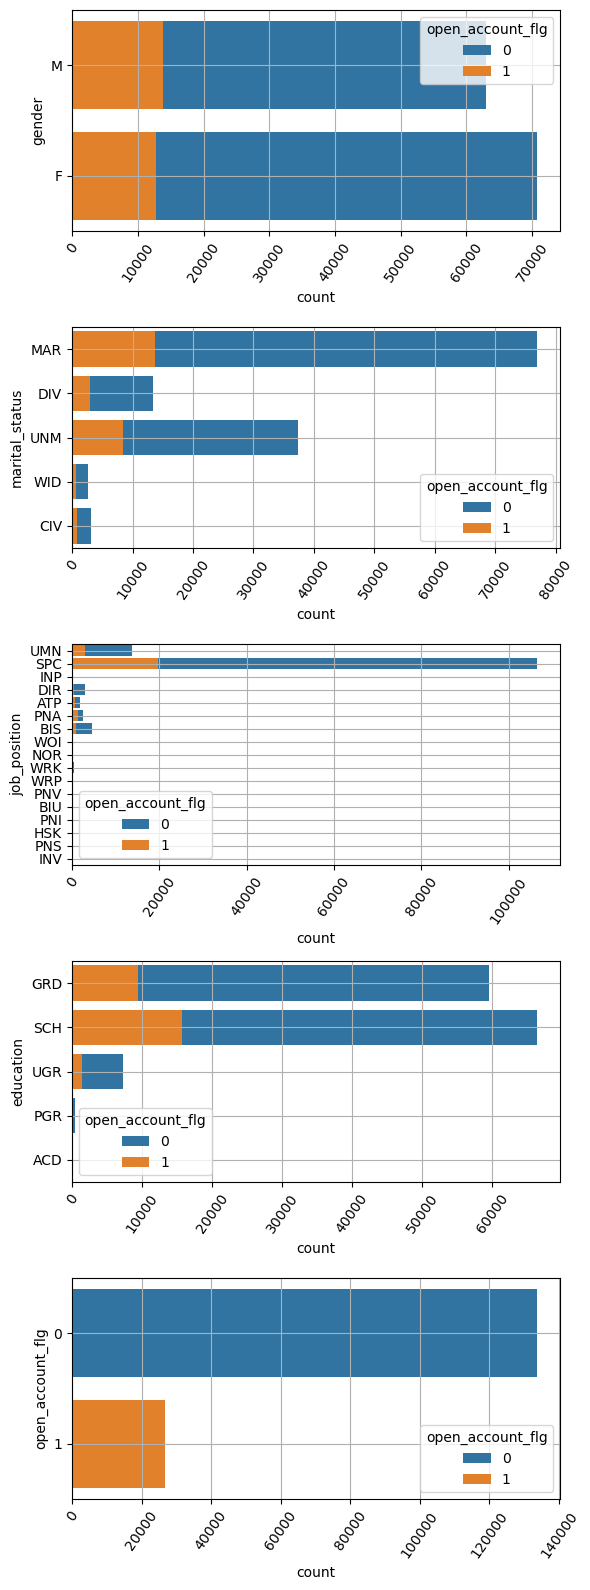

In [55]:
# Графики количества наблюдений в каждом вещественном признаке

fig, ax = plt.subplots(nrows=data_obj.shape[1]-1, ncols=1, squeeze=False, figsize=[6, 16])
a=0
for i in data_obj.iloc[:,:-1]:
    sns.countplot(data=data_obj, y=i, ax=ax[a,0], hue='open_account_flg', dodge=False)
    #sns.histplot(data=data_obj,y=data_obj[i], ax=ax[a,0], hue='open_account_flg', kde=True)
    ax[a,0].grid(True)
    ax[a,0].tick_params(axis='x', rotation=55)
    plt.tight_layout()
    a+=1
plt.show()

<Axes: xlabel='living_region', ylabel='Count'>

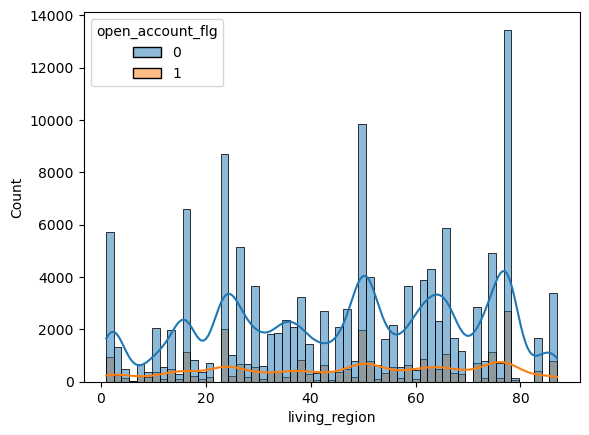

In [48]:
# Отдельный график для региона

sns.histplot(data=data_obj,x =data_obj['living_region'], hue='open_account_flg', kde=True)

 Исходя из графиков, можно сказать:
*  график переменной региона имеет разную форму распределения в зависимости от целевой переменной 
* мужчины чаще берут кредит
* для других признаков целевая переменная распределена равномерно

In [56]:
# Использую призак 'gender' для превращения его в категориальную переменную методом OneHotEncoder

def nom_class(data):
    nom_enc = OneHotEncoder(sparse_output=False)
    categorical_columns = list(['gender'])
    encoded_data = nom_enc.fit_transform(data[categorical_columns])
    encoded_df = pd.DataFrame(encoded_data.astype(int), columns=nom_enc.get_feature_names_out(categorical_columns))
    return encoded_df

In [57]:
nom_data_obj=nom_class(data_obj)

In [58]:
nom_data_obj_test=nom_class(test_df)

# Работа с числовыми данными

In [62]:
train_nums=train_df.drop(data_obj.columns, axis=1)

In [65]:
train_nums['open_account_flg']=train_df['open_account_flg']

In [127]:
train_nums

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,48,59998.00,10,1.60,0.770249,30000.0,1.0,1.0,0
1,28,10889.00,6,1.10,0.248514,43000.0,2.0,0.0,0
2,32,10728.00,12,1.10,0.459589,23000.0,5.0,0.0,0
3,27,12009.09,12,1.10,0.362536,17000.0,2.0,0.0,0
4,45,16908.89,10,1.10,0.421385,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...
160223,27,64867.00,12,1.10,0.535257,40000.0,6.0,0.0,0
160224,24,17640.00,6,1.60,0.573287,30000.0,1.0,0.0,0
160225,31,27556.47,10,1.32,0.416098,40000.0,1.0,0.0,0
160226,53,6189.00,12,1.10,0.482595,31000.0,2.0,0.0,0


In [66]:
test_obj=test_df.T.loc[test_df.dtypes=='object'].T
test_nums=test_df.drop(test_obj.columns, axis=1)
test_nums

,client_id,age,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count
0,170747,48,16558.00,10,1.10,0.370409,19.0,34000,2.0,0.0
1,170748,29,7028.72,6,1.40,0.377281,42.0,19000,3.0,0.0
2,170749,20,13019.00,10,1.60,0.538515,31.0,25000,1.0,0.0
3,170750,41,9379.00,10,1.10,0.482520,38.0,30000,0.0,0.0
4,170751,31,13990.00,6,1.43,0.485914,43.0,20000,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
86749,262681,39,18168.00,12,1.10,0.564620,16.0,30000,2.0,0.0
86750,262682,41,10114.00,12,1.90,0.347262,78.0,30000,1.0,0.0
86751,262683,33,14807.00,6,1.60,0.404430,32.0,30000,0.0,0.0
86752,262684,25,19718.00,10,1.40,0.341982,60.0,20000,1.0,0.0


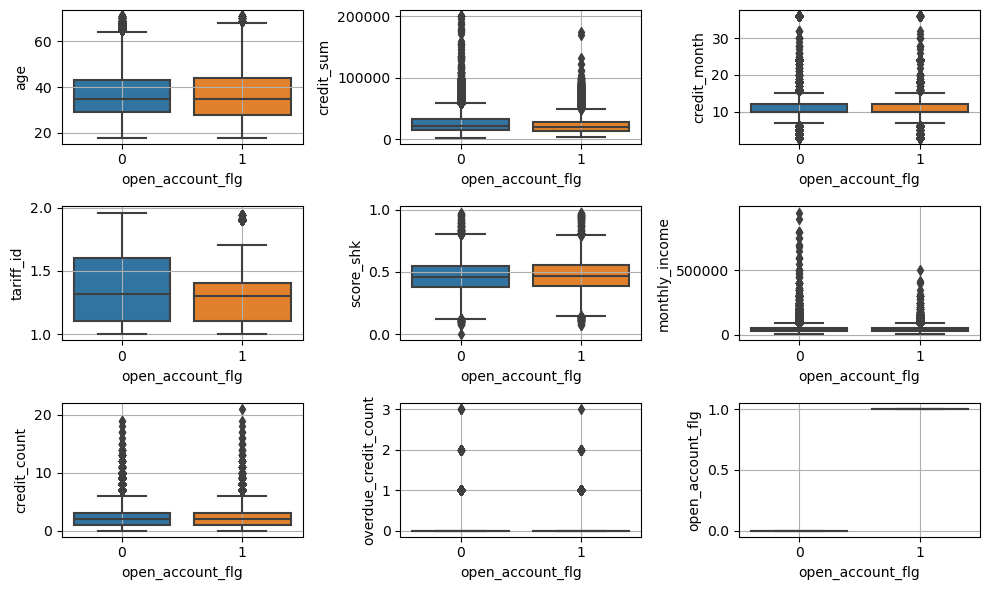

In [67]:
# Боксплоты для числовых признаков 

plt.figure(figsize=(10, 6))
for i in np.arange(0,9):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=train_nums, x='open_account_flg', y=train_nums.columns[i],width = 0.8)
    plt.grid(True)
    plt.tight_layout()


* После уровня ежемесячного дохода в 500 000 категория 1 исчезает на графике боксплот, это та граница, когда  человеку не нужен кредит, тк он в состояния приобретать товары без него 
* самой важной фичей является traffic_id поскольку графики отличаются сильнее всего и менее всего выбросов
* меньше всего влияет фича age, тк графики более всех остальных повторяют друг друга
* кол-во просроченных кредитов для основной массы людей = 0, для остальный 1,2,3

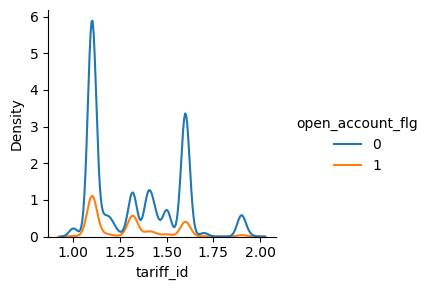

In [68]:
sns.displot(train_nums, x='tariff_id', hue='open_account_flg', kind='kde', height=3)

In [70]:
# Анализ просроченных кредитов

train_df['overdue_credit_count'].value_counts()

0.0    152901
1.0      7276
2.0        46
3.0         5
Name: overdue_credit_count, dtype: int64

In [71]:
train_df[train_df['overdue_credit_count']==3]

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
25154,M,33,DIV,SPC,43191.0,6,1.4,0.328984,GRD,86.0,50000.0,4.0,3.0,0
27804,M,25,UNM,SPC,11111.0,6,1.3,0.582469,GRD,77.0,100000.0,4.0,3.0,0
59939,M,29,UNM,SPC,31491.0,12,1.5,0.490006,GRD,66.0,45000.0,6.0,3.0,0
61551,M,33,DIV,SPC,43191.0,6,1.6,0.328984,GRD,86.0,50000.0,4.0,3.0,0
78197,M,29,UNM,SPC,31491.0,6,1.1,0.490006,GRD,66.0,45000.0,6.0,3.0,1


* Самое большое кол-во просроченых кредитов (3) наблюдаются у мужчин, 25-35 лет, неженатых или разведенных, из Москвы, Мо, Ханты-Мансийский Автономного Округа - Югра,Свердловской Обл

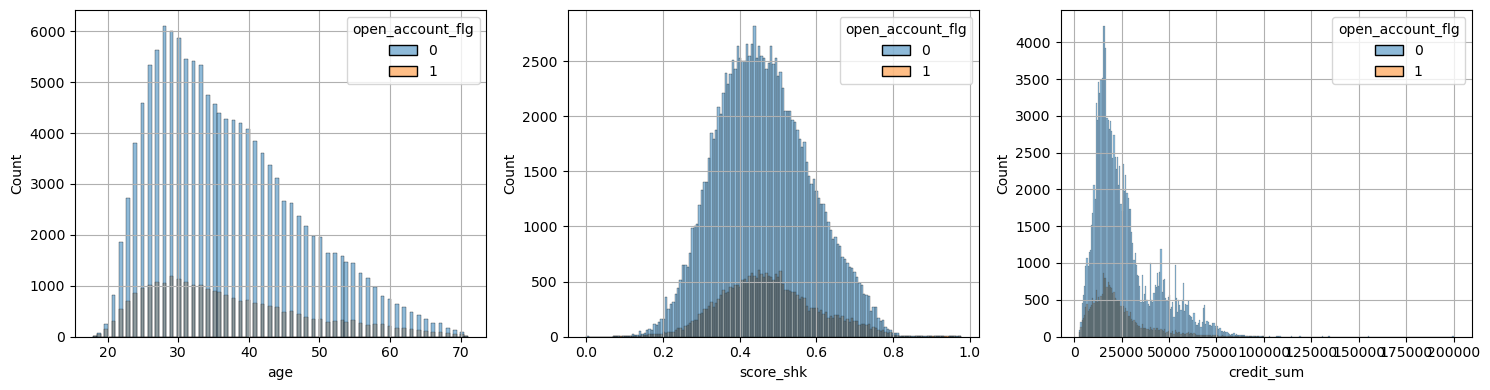

In [72]:
train_nums_3=train_nums[['age', 'score_shk', 'credit_sum','open_account_flg']]
plt.figure(figsize=(15, 4))
for i in np.arange(0,3):
    plt.subplot(1,3,i+1)
    sns.histplot(data=train_nums_3,x =train_nums_3.columns[i], hue='open_account_flg')
    plt.grid(True)
    plt.tight_layout()

* загадочная фича 'score_shk' имеет идеальное гаусово распределние - некая оценка клиентов? 

In [96]:
# Окончательный набор данных имеет все числовые признаки,признак региона и признак пола

dataset_fin=pd.concat([train_nums, data_obj['living_region'], nom_data_obj], axis=1)

In [76]:
dataset_fin

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,living_region,gender_F,gender_M
0,48,59998.00,10,1.60,0.770249,30000.0,1.0,1.0,0,23.0,0,1
1,28,10889.00,6,1.10,0.248514,43000.0,2.0,0.0,0,77.0,1,0
2,32,10728.00,12,1.10,0.459589,23000.0,5.0,0.0,0,64.0,0,1
3,27,12009.09,12,1.10,0.362536,17000.0,2.0,0.0,0,34.0,1,0
4,45,16908.89,10,1.10,0.421385,25000.0,1.0,0.0,0,74.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
160223,27,64867.00,12,1.10,0.535257,40000.0,6.0,0.0,0,16.0,1,0
160224,24,17640.00,6,1.60,0.573287,30000.0,1.0,0.0,0,78.0,1,0
160225,31,27556.47,10,1.32,0.416098,40000.0,1.0,0.0,0,25.0,1,0
160226,53,6189.00,12,1.10,0.482595,31000.0,2.0,0.0,0,58.0,1,0


In [77]:
dataset_fin_test=pd.concat([test_nums, nom_data_obj_test], axis=1)
dataset_fin_test.drop('client_id', inplace=True, axis=1)

In [78]:
dataset_fin_test

,age,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_F,gender_M
0,48,16558.00,10,1.10,0.370409,19.0,34000,2.0,0.0,1,0
1,29,7028.72,6,1.40,0.377281,42.0,19000,3.0,0.0,0,1
2,20,13019.00,10,1.60,0.538515,31.0,25000,1.0,0.0,1,0
3,41,9379.00,10,1.10,0.482520,38.0,30000,0.0,0.0,1,0
4,31,13990.00,6,1.43,0.485914,43.0,20000,2.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
86749,39,18168.00,12,1.10,0.564620,16.0,30000,2.0,0.0,0,1
86750,41,10114.00,12,1.90,0.347262,78.0,30000,1.0,0.0,0,1
86751,33,14807.00,6,1.60,0.404430,32.0,30000,0.0,0.0,0,1
86752,25,19718.00,10,1.40,0.341982,60.0,20000,1.0,0.0,1,0


## Нормализация данных

In [79]:
# приведение данных к одному диапазону - нормализация данных

def scal(dataset_fin):
    scaler=MinMaxScaler()
    scaler.fit(dataset_fin)
    scaled = scaler.transform(dataset_fin)
    scaled = pd.DataFrame(scaled, index=dataset_fin.index, columns=dataset_fin.columns)
    scaled.reset_index(inplace=True,drop=True)
    return scaled, scaler

In [80]:
data_sc, scaler= scal(dataset_fin)

In [83]:
data_sc.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,living_region,gender_F,gender_M
0,0.566038,0.290281,0.212121,0.625000,0.789088,0.026455,0.047619,0.333333,0.0,0.255814,0.0,1.0
1,0.188679,0.041330,0.090909,0.104167,0.254592,0.040212,0.095238,0.000000,0.0,0.883721,1.0,0.0
2,0.264151,0.040514,0.272727,0.104167,0.470830,0.019048,0.238095,0.000000,0.0,0.732558,0.0,1.0
3,0.169811,0.047009,0.272727,0.104167,0.371403,0.012698,0.095238,0.000000,0.0,0.383721,1.0,0.0
4,0.509434,0.071847,0.212121,0.104167,0.431691,0.021164,0.047619,0.000000,0.0,0.848837,0.0,1.0


In [81]:
data_sc_test, scaler_test= scal(dataset_fin_test)

In [97]:
data_sc_test

,age,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_F,gender_M
0,0.566038,0.068822,0.212121,0.106383,0.380195,0.209302,0.048571,0.090909,0.0,1.0,0.0
1,0.207547,0.020450,0.090909,0.425532,0.387249,0.476744,0.027143,0.136364,0.0,0.0,1.0
2,0.037736,0.050858,0.212121,0.638298,0.552743,0.348837,0.035714,0.045455,0.0,1.0,0.0
3,0.433962,0.032381,0.212121,0.106383,0.495268,0.430233,0.042857,0.000000,0.0,1.0,0.0
4,0.245283,0.055787,0.090909,0.457447,0.498752,0.488372,0.028571,0.090909,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
86749,0.396226,0.076995,0.272727,0.106383,0.579537,0.174419,0.042857,0.090909,0.0,0.0,1.0
86750,0.433962,0.036112,0.272727,0.957447,0.356437,0.895349,0.042857,0.045455,0.0,0.0,1.0
86751,0.283019,0.059934,0.090909,0.638298,0.415115,0.360465,0.042857,0.000000,0.0,0.0,1.0
86752,0.132075,0.084863,0.212121,0.425532,0.351017,0.686047,0.028571,0.045455,0.0,1.0,0.0


# Построение моделей

In [84]:
## кол-во элементов в каждом классе целевой переменной 

train_df['open_account_flg'].value_counts()

0    133625
1     26603
Name: open_account_flg, dtype: int64

In [86]:
133625/ (26603+133625)

0.833967845819707

* Данные не сбалансированны 
0.83397 - самая примитивная модель, дает точность, если каждый раз предсказывать наиболее распространнный класс


In [87]:
# Деление всего набора на тренировочный и тестовый

def split(scaled_data):
    train_df, test_df = train_test_split(scaled_data, test_size=0.3, stratify=scaled_data['open_account_flg'], shuffle=True, random_state=RANDOM_SEED)
    return train_df, test_df

In [88]:
# Деление на данные и метки для них

df_train, df_test=split(data_sc)
TARGET_COLUMN='open_account_flg'
x_columns = data_sc.columns
x_columns = x_columns[x_columns != TARGET_COLUMN]
y_scal_tren = df_train[TARGET_COLUMN]
X_scal_tren = df_train[x_columns]
y_scal_test = df_test[TARGET_COLUMN]
X_scal_test = df_test[x_columns]

In [89]:
#функция обучения модели и получения спрогнозированных значений

def pred(model, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test):
    model.fit(X_scal_tren, y_scal_tren)
    y_pred = model.predict(X_scal_test)
    report = classification_report(y_scal_test, y_pred, digits=5)
    return print(report),  y_pred 

In [ ]:
log_reg = LogisticRegression(random_state=RANDOM_SEED, max_iter=10000)
_,y_pred_log=pred(log_reg, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

In [91]:
rf_clf = RandomForestClassifier(max_depth=14, n_estimators=90, max_features='sqrt', 
                                random_state=RANDOM_SEED)
_,y_pred_rf_clf=pred(rf_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

         0.0    0.83691   0.99581   0.90947     40088
         1.0    0.54595   0.02531   0.04838      7981

    accuracy                        0.83468     48069
   macro avg    0.69143   0.51056   0.47893     48069
weighted avg    0.78860   0.83468   0.76650     48069



In [92]:
gb_clf = GradientBoostingClassifier(n_estimators=90, max_depth=14, max_features='sqrt', random_state=RANDOM_SEED)
_,y_pred_gb_clf=pred(gb_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

         0.0    0.84223   0.97732   0.90476     40088
         1.0    0.41393   0.08044   0.13470      7981

    accuracy                        0.82841     48069
   macro avg    0.62808   0.52888   0.51973     48069
weighted avg    0.77112   0.82841   0.77691     48069



In [ ]:
L_gbm= lgb.LGBMClassifier()
_,y_pred_lgb = pred(L_gbm, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

[LightGBM] [Info] Number of positive: 26603, number of negative: 133625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 160228, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166032 -> initscore=-1.614013
[LightGBM] [Info] Start training from score -1.614013
              precision    recall  f1-score   support

         0.0    0.83958   0.99636   0.91127     40088
         1.0    0.70505   0.04373   0.08235      7981

    accuracy                        0.83819     48069
   macro avg    0.77231   0.52004   0.49681     48069
weighted avg    0.81724   0.83819   0.77365     48069



In [94]:
base_est = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_SEED)
bagging_clf = BaggingClassifier(base_est, n_estimators=100, random_state=RANDOM_SEED)

_,y_pred_gb_clf=pred(bagging_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)


              precision    recall  f1-score   support

         0.0    0.83555   0.99860   0.90983     40088
         1.0    0.64557   0.01278   0.02506      7981

    accuracy                        0.83492     48069
   macro avg    0.74056   0.50569   0.46745     48069
weighted avg    0.80401   0.83492   0.76293     48069



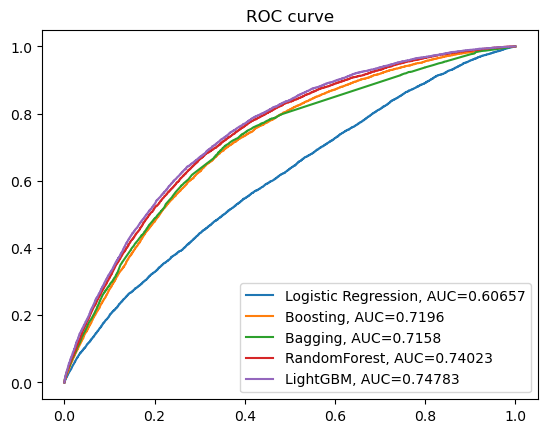

In [95]:
y_pred1 = log_reg.predict_proba(X_scal_test)[:, 1]
y_pred4 = rf_clf.predict_proba(X_scal_test)[:, 1]
y_pred2=gb_clf.predict_proba(X_scal_test)[:, 1]
y_pred3=bagging_clf.predict_proba(X_scal_test)[:, 1]
y_pred5=L_gbm.predict_proba(X_scal_test)[:, 1]

fpr1, tpr1, _ = metrics.roc_curve(y_scal_test, y_pred1)
fpr2, tpr2, _ = metrics.roc_curve(y_scal_test, y_pred2)
fpr3, tpr3, _ = metrics.roc_curve(y_scal_test, y_pred3)
fpr4, tpr4, _ = metrics.roc_curve(y_scal_test, y_pred4)
fpr5, tpr5, _ = metrics.roc_curve(y_scal_test, y_pred5)

auc1 = round(metrics.roc_auc_score(y_scal_test, y_pred1), 5)
auc2 = round(metrics.roc_auc_score(y_scal_test, y_pred2), 5)
auc3 = round(metrics.roc_auc_score(y_scal_test, y_pred3), 5)
auc4 = round(metrics.roc_auc_score(y_scal_test, y_pred4), 5)
auc5 = round(metrics.roc_auc_score(y_scal_test, y_pred5), 5)


plt.plot(fpr1,tpr1,label="Logistic Regression, AUC="+str(auc1))
plt.plot(fpr2,tpr2,label="Boosting, AUC="+str(auc2))
plt.plot(fpr3,tpr3,label="Bagging, AUC="+str(auc3))
plt.plot(fpr4,tpr4,label="RandomForest, AUC="+str(auc4))
plt.plot(fpr5,tpr5,label="LightGBM, AUC="+str(auc5))
plt.title('ROC curve')
plt.legend()


    
* Самый высокий показатель AUC  у LightGBM, также это самый быстрый классификатор
* Самый низкий показатель AUC  у логистической регрессии
* поскольку наблюдается дисбаланс классов: 
    * логистическая регрессия не предсказывает 1 класс;
    * модель опорных векторов использовать невозможно; 





Использование модели ligt gradient boosting на всем обработанном тренировочном наборе данных 
Предсказание для обработанного тестового набора 

In [98]:
df_train=data_sc
df_test=data_sc_test
TARGET_COLUMN='open_account_flg'
x_columns = data_sc.columns
x_columns = x_columns[x_columns != TARGET_COLUMN]
y_scal_tren = df_train[TARGET_COLUMN]
X_scal_tren = df_train[x_columns]

L_gbm= lgb.LGBMClassifier()
L_gbm.fit(X_scal_tren, y_scal_tren)
y_pred = L_gbm.predict(df_test)

[LightGBM] [Info] Number of positive: 26603, number of negative: 133625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 160228, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166032 -> initscore=-1.614013
[LightGBM] [Info] Start training from score -1.614013


In [100]:
len(y_pred)

86754

In [122]:
test_df['open_account_flg']=y_pred
test_df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,170747,F,48,MAR,UMN,16558.00,10,1.10,0.370409,GRD,19.0,34000,2.0,0.0,0.0
1,170748,M,29,MAR,SPC,7028.72,6,1.40,0.377281,SCH,42.0,19000,3.0,0.0,0.0
2,170749,F,20,UNM,SPC,13019.00,10,1.60,0.538515,SCH,31.0,25000,1.0,0.0,0.0
3,170750,F,41,MAR,SPC,9379.00,10,1.10,0.482520,GRD,38.0,30000,0.0,0.0,0.0
4,170751,F,31,MAR,SPC,13990.00,6,1.43,0.485914,GRD,43.0,20000,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86749,262681,M,39,MAR,SPC,18168.00,12,1.10,0.564620,SCH,16.0,30000,2.0,0.0,0.0
86750,262682,M,41,MAR,SPC,10114.00,12,1.90,0.347262,SCH,78.0,30000,1.0,0.0,0.0
86751,262683,M,33,UNM,SPC,14807.00,6,1.60,0.404430,SCH,32.0,30000,0.0,0.0,0.0
86752,262684,F,25,MAR,SPC,19718.00,10,1.40,0.341982,GRD,60.0,20000,1.0,0.0,0.0
